# Sentiment Analysis of Tweets using spaCy, VADER, and Scikit-Learn

This notebook will showcase two approaches to conducting sentiment analysis in a natural language processing (NLP) pipeline.  

Both approach will attempt to resolve tweets to a continuum of sentiment based on the content of each tweet.  The sentiment values produced could then further be classified into postive vs negative groups, which would be as simple as choosing an arbitrary threshold sentiment value (i.e. 0) and sorting each tweet into their respective bins.

1. Lexicon Approach

    - This approach will cross reference the salient words of each tweet against a lexicon that prescribes a sentiment valence value, which will be an integer value. 
    - These integer values will be summed for each tweet to compute its compound sentiment.
    
<br>

2. Machine Learning Approach

 - The second approach will train a machine learning regression model after representing each tweet as a vector in some n-dimensional space.
 - Each tweet will be transformed into a sparse matrix within a high dimensional space so that they can be presented to our regression models as numbers.

<br>

All the code for this notebook will be in Python.

## 1. Setup

We're going to write a tiny amount of functions ourselves, but mostly leverage functions from open-source packages.

This part is really <font color=green>**import**</font>ant.

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

In [2]:
def tokenize(x, flatten=False):
    '''Preprocess the input text by tokenizing each word,
    removing stopwords, removing any punctuation, and 
    converting words into their lemmas.
    
    Args:
        x: Corpus list where each item is a text document
        flatten: Decide if the returned list should be flat 1D or 2D
    
    Returns:
        Produces a list of preprocessed lemmas in the same order as x.
    '''
    
    toktext = []
    for t in x:
        # Create a tokenized lang obj for each doc
        doc = nlp(t)
        
        # Remove stopwords, punctuation & pronouns, then record lemmas
        lemmas = [token.lemma_ for token in doc 
                   if (not token.is_stop and 
                       not token.is_punct and 
                       token.lemma_ != '-PRON-')]
        
        if flatten:
            # Concatenate the lemma strings into a single string 
            concat_lemma = " ".join(lemmas)
            toktext.append(concat_lemma)
        
        else:
            toktext.append(lemmas)
        
    return toktext


def sentiment_scatterplot(X, y, title=""):
    '''Graph a scatter plot of the sentiment scores as a function
    of tweet length.
    
    Args:
        X: List of tweet length values
        y: List of sentiment scores
        title: The graph title
    
    Returns:
        A matplotlib pyplot object
    '''
    plt.figure(figsize=(10, 7))

    # Define colormap scale
    norm = Normalize(-1,1)
    colors = [[norm(-1.0), "crimson"],
              [norm( 0.0), "darkgrey"],
              [norm( 1.0), "dodgerblue"]]

    cmap = LinearSegmentedColormap.from_list("", colors)

    plt.scatter(X, y, c=y, cmap=cmap)
    plt.xlabel('Tweet Character Count')
    plt.ylabel('Sentiment')
    plt.title(title)
    
    return plt

## 2. Read Datasets into Memory

The *Sentiment140_test* dataset is going to serve as our target dataset, where we will be interest in discovering what the spread of sentiment looks like for these 498 tweets.
([GitHub](https://github.com/rmaestre/Sentiwordnet-BC/blob/master/test/testdata.manual.2009.06.14.csv), [Kaggle](https://www.kaggle.com/pirateshadow/sentiment140-test))

The machine learning training dataset we're going to use comes from the VADER package.  It is a list of tweet-like text with labelled sentiment values. ([GitHub](https://github.com/cjhutto/vaderSentiment#python-code-example))

In [3]:
target_data_fpath = '~/Documents/datasets/nlp/testdata.manual.2009.06.14.csv'
target_df = pd.read_csv(target_data_fpath, header=None)

mltrain_fpath = '~/Documents/datasets/nlp/tweets_GroundTruth.txt'
mltrain_df = pd.read_csv(mltrain_fpath, delimiter='\t', 
                         engine='python', header=None,
                         names = ['id', 'mean_sentiment_rating', 'tweet_text'])

## 3. Tokenize Words with spaCy

The `spaCy` package provides a concise way to preprocess our tweet texts into tokens for our NLP pipeline.  

The `spaCy` package can be thought of as an industry-focused `NLTK` package.

In [4]:
# Initialize spaCy English model
nlp = spacy.load('en')

# Isolate the text from our target dataframe
target_tweets = target_df.iloc[:, 5].tolist()
print('Example of a target tweet:\n', target_tweets[1])

Example of a target tweet:
 Reading my kindle2...  Love it... Lee childs is good read.


Our tokenization steps will be: 

1. Remove stopwords

2. Remove punctuation

3. Remove pronounds

4. Convert words to lemma

In [5]:
lexicon_target_tokens = tokenize(target_tweets, flatten=True)
print('Example of same tweet tokenized:\n', lexicon_target_tokens[1])

Example of same tweet tokenized:
 read kindle2   love lee child good read


## 4. Lexicon Approach to Sentiment Analysis

We will call on the `VADER` lexicon to compute the summed sentiments using each tweets' lemmas.

In [6]:
analyzer = SentimentIntensityAnalyzer()
sentiments = []

for tweet in lexicon_target_tokens:
    polarity = analyzer.polarity_scores(tweet)
    sentiments.append(polarity)
    
print('Example of sentiment value for same target tweet:\n', sentiments[1]['compound'])

Example of sentiment value for same target tweet:
 0.7964


Below is the explanation, in their own words, of how VADER computes the compound (i.e. combined/summed) sentiment for each tweet.

"The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

[GitHub](https://github.com/cjhutto/vaderSentiment#python-code-example)

### Lexicon Approach Visualized

Let's get a pre-attentive sense for what the sentiments look like.

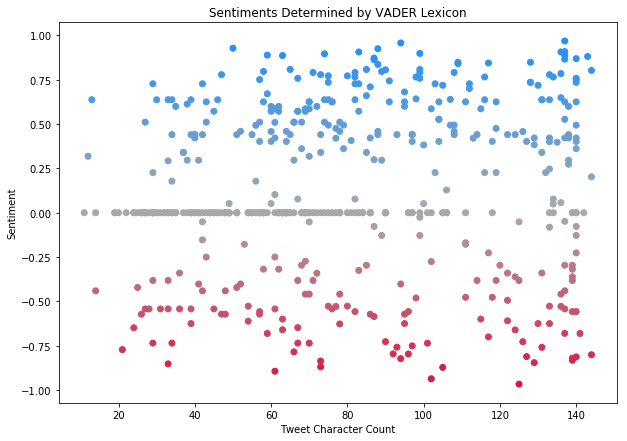

In [7]:
X =  [len(tweet) for tweet in target_tweets]
y = [x['compound'] for x in sentiments]
ptitle = 'Sentiments Determined by VADER Lexicon'

sentiment_scatterplot(X, y, ptitle);

## 5. Machine Learning Approach to Sentiment Analysis

This approach is going to train a machine learning model to resolve the sentiment for each of the tweets within our target dataset.  We will need to vectorize our tweet text data as an additional preprocessing step in this approach.

In [8]:
mltrain_tweets = [text for text in mltrain_df.tweet_text]

# Flatten the output of tokenize and save as a new column within our machine learning training dataframe
mltrain_df['tokens'] = tokenize(mltrain_tweets, flatten=True)
mltrain_df.head(5)

,id,mean_sentiment_rating,tweet_text,tokens
0,1,2.726316,Somehow I was blessed with some really amazing...,somehow bless amazing friend life love send en...
1,2,1.443299,Yay. Another good phone interview.,yay another good phone interview
2,3,2.873684,We were 17 deep last night &amp; the love was ...,17 deep night amp love strong everybody feel e...
3,4,2.857143,"LMAO, AMAZING!",lmao amazing
4,5,-2.154639,Two words that should die this year: Sexting a...,two word die year sexting jegging die die die


We will vectorize our tweet data by creating a sparse matrix of token counts to represent the tweets as numerical values using `CountVectorizer` from scikit-learn.

We will constrain the high dimensional space of our vectors by setting the `max_features` to that of our target dataset (the smaller of the two datasets, with a lesser dimensional space).

In [9]:
# Initialize vectorizer object
countvec = CountVectorizer()

# First pass at vectorizing tweets
target_dataset = countvec.fit_transform(target_tweets)
training_dataset = countvec.fit_transform(mltrain_df.tokens)

# Set the max feature space to the smaller of the two datasets in an automated way
ndims = [np.shape(x)[1] for x in [target_dataset, training_dataset]]
smaller = min(ndims)

# Re-fit the vectorizers, limit their dimensional space to the smaller of the 2 spaces
countvec = CountVectorizer(max_features=smaller)

target_dataset = countvec.fit_transform(target_tweets)
training_dataset = countvec.fit_transform(mltrain_df.tokens)

Partition the training data into train & test components

In [10]:
X_train, X_test, y_train, y_test = train_test_split(training_dataset, 
                                                    mltrain_df.mean_sentiment_rating)

Here we will pick a regression model to train and fit it to the preprocessed Twitter data.  We're going to fit a linear support vector machine and a stochastic gradient descent model.

We will use the mean squared error in attempt to get a sense for which model fits the regression better (beware, the plot thickens later).

#### A. Linear Support Vector Regression

In [11]:
# Initialize and fit the model
svr_model = LinearSVR()
svr_model.fit(X_train, y_train);

# Evaluate test set accuracy using MSE
y_pred = svr_model.predict(X_test)
mean_squared_error(y_test, y_pred)

/home/mindless/Documents/python/porter/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


1.4402696995105153

#### B. Stochastic Gradient Descent

When training this model the first time with default hyperparamters, it was shown to give misleading sentiment predictions.  To prove this behavior to you I will train two variants of the same model:

- One untuned with default hyperparameters

- One tuned with mildly optimized hyperparameters

In [12]:
# Model with Default Hyperparameters
untuned_sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)
untuned_sgd_model.fit(X_train, y_train);

# Evaluate
y_pred = untuned_sgd_model.predict(X_test)
mean_squared_error(y_test, y_pred)

1.0670625585021356

In [13]:
# Model with Optimized Hyperparameters
tuned_sgd_model = SGDRegressor(max_iter=4000, tol=1e-5)
tuned_sgd_model.fit(X_train, y_train);

# Evaluate
y_pred = tuned_sgd_model.predict(X_test)
mean_squared_error(y_test, y_pred)

1.2637741217598113

The untuned stochastic gradient descent model appears to be slightly more accurate than the tuned variant but we will quickly see that might not be the end of the story.

### Apply ML Models to our Twitter Data and Visualize

Let's use our trained models to discern the sentiment spread of our target tweet dataset.

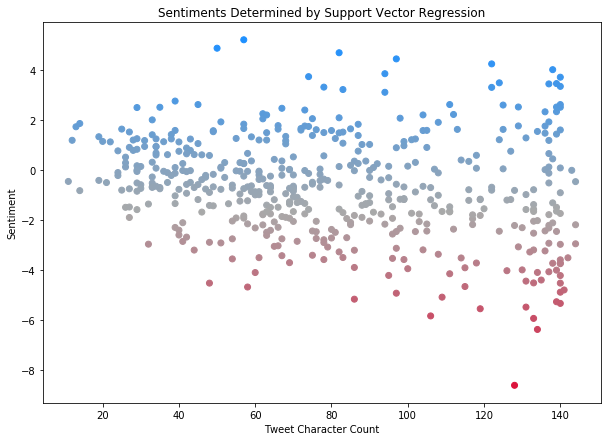

In [14]:
target_svr_sentiments = svr_model.predict(target_dataset)
sentiment_scatterplot(X, 
                      y = target_svr_sentiments, 
                      title = 'Sentiments Determined by Support Vector Regression');

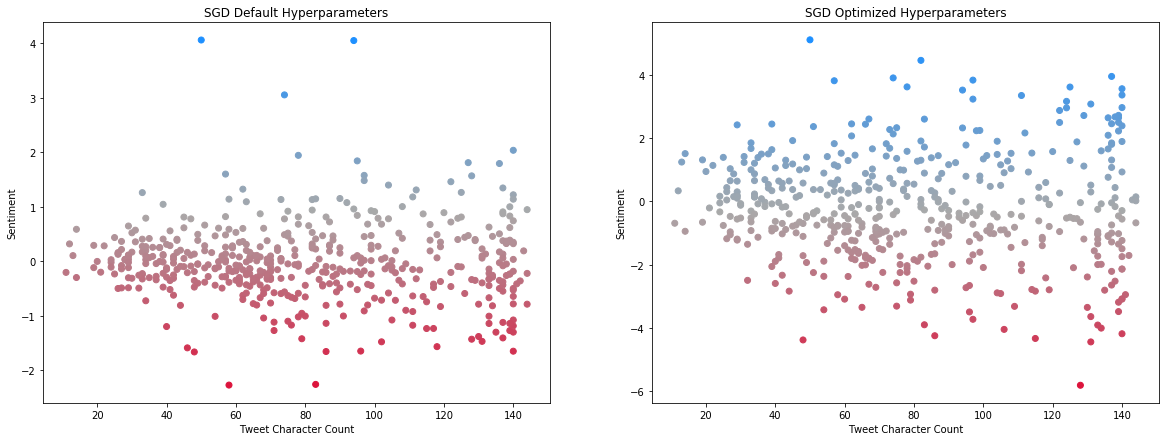

In [15]:
# Predict sentiments with both sets of hyperparameters
target_default_sgd_sentiments = untuned_sgd_model.predict(target_dataset)
target_optimized_sgd_sentiments = tuned_sgd_model.predict(target_dataset)

# Throw both scatter plots on the same canvas
fig, [ax1, ax2] = plt.subplots(1, 2,
                               sharey = False,
                               constrained_layout = False,
                               figsize = (20, 7));
# Colormap
norm = Normalize(-1,1)
colors = [[norm(-1.0), "crimson"],
          [norm( 0.0), "darkgrey"],
          [norm( 1.0), "dodgerblue"]]
cmap = LinearSegmentedColormap.from_list("", colors)

# Untuned Model First
ax1.scatter(X, target_default_sgd_sentiments, 
            c=target_default_sgd_sentiments, cmap=cmap)
ax1.set_xlabel('Tweet Character Count')
ax1.set_ylabel('Sentiment')
ax1.set_title('SGD Default Hyperparameters')

# Tuned Model Second
ax2.scatter(X, target_optimized_sgd_sentiments,
            c=target_optimized_sgd_sentiments, cmap=cmap)
ax2.set_xlabel('Tweet Character Count')
ax2.set_ylabel('Sentiment')
ax2.set_title('SGD Optimized Hyperparameters');

The unoptomized model which was using the default hyperparameters viewed the majority of tweets as negative.

In [16]:
# View a slice of tweets with predicted sentiment
pd.options.display.max_colwidth = 222
sentiment_slice = {'tweet': target_df.iloc[21:28, 5].to_list(),
                   'SVR': target_svr_sentiments[21:28],
                   'Default SGD': target_default_sgd_sentiments[21:28],
                   'Optimized SGD': target_optimized_sgd_sentiments[21:28]}
pd.DataFrame(sentiment_slice)

,tweet,SVR,Default SGD,Optimized SGD
0,lebron and zydrunas are such an awesome duo,0.785830,0.163570,1.298515
1,@wordwhizkid Lebron is a beast... nobody in the NBA comes even close.,-1.300559,-0.238263,-0.539635
2,downloading apps for my iphone! So much fun :-) There literally is an app for just about anything.,2.074565,0.682479,2.228611
3,"good news, just had a call from the Visa office, saying everything is fine.....what a relief! I am sick of scams out there! Stealing!",-3.199993,-0.142223,-1.343660
4,http://twurl.nl/epkr4b - awesome come back from @biz (via @fredwilson),-1.075843,-0.299284,-0.209652
5,In montreal for a long weekend of R&amp;R. Much needed.,-0.032649,-0.102763,0.197082
6,Booz Allen Hamilton has a bad ass homegrown social collaboration platform. Way cool! #ttiv,0.098834,-0.184452,0.314544


The SGD algorithm appears more skeptical to report tweet sentiments as very positive than the SVR.

## 6. Discussion

### Lexicon versus Machine Learning Approach

The differences in computation between these two approaches are visible in the scatter plots.   For the lexicon approach, the spread of sentiment appears more quantized, where sentiment values appear to be constrained to a set of values rather than being continuous.  The scatter plots produced by the machine learning algorithms have a much more granular appear as values are spread along the vertical axis as more of a continuum.

This behavior can be explained when considering how these approaches are predicting the sentiment values.  The lexicon approach is summing integer values, then normalizing those sums to a scale between -1 and 1.  The machine learning algorithms are resolving a probability of a lemma for being positive or negative and then multiplying those probablilites for all lemmas within a tweet.  The product of the machine learning algorithm therefore has more nuance than that of the lexicon, because the lexicon approach is constrained to the set of possible integer sums while the machine learning approach isn't.


### Linear Support Vector Regression vs Stochastic Gradient Descent

These results were interesting.  Under the default hyperparameters the SGD model reported almost all tweets as carrying negative sentiment.  Only after tuning the hyperparameters did the sentiment distribution begin to take a similar shape to that reported by SVR and the lexicon approach.  As the tolerance hyperparameter was decreased on a logarithmic scale, the overall average sentiment of the target dataset increased.  This is evidence to suggest that a grid search or other hyperparameter optimization schemes are strongly encouraged when reporting text sentiments using SGD.  Don't leave your SGD hyperparameters unoptimized.

## 7. Conclusion

Just as there are multiple ways to skin a cat, there are options available to you when performing sentiment analysis.  Cross-referencing lemmas of tweets to their mapped sentiment values using a lexicon is a quick and dirty method for resolving sentiments.  However, this approach makes no promises of attempting to understand the meaning of these texts and produces sentiment values that are constrained to a discrete scale.  The sentiments resolved using a machine learning algorithm are more nuanced but require more attention with regard to their hyperparameter values, which can shift all sentiments.  

You have to be more careful when using the more complicated algorithms, but if done correctly, they can give better results.


## 8. TL;DR

I'm afraid we've confirmed the obvious here with this one.  If your targetting sentiment accuracy, training a machine learning model to resolve sentiments appears to be better than just using a lexicon mapping.